In [1]:
%matplotlib inline
import time
import numpy as np
import torch
from torch import nn
from torch.optim import lr_scheduler
import math
from mpl_toolkits import mplot3d
from d2l import torch as d2l

# 12.1. Optimization and Deep Learning

## 12.1.1. Goal of Optimization

g(empirical risk) is less smooth than f(risk)

In [2]:
def f(x):
    return x * torch.cos(np.pi * x)


def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

the minimum of the empirical risk on a training dataset may be at a different location from the minimum of the risk (generalization error)

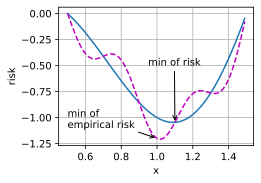

In [3]:
def annotate(text, xy, xytext):  # @save
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext, arrowprops=dict(arrowstyle="->"))


x = torch.arange(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], "x", "risk")
annotate("min of\nempirical risk", (1.0, -1.2), (0.5, -1.1))
annotate("min of risk", (1.1, -1.05), (0.95, -0.5))

## 12.1.2. Optimization Challenges in Deep Learning

### 12.1.2.1. Local Minima


$$f(x) = x \cdot \textrm{cos}(\pi x) \textrm{ for } -1.0 \leq x \leq 2.0$$

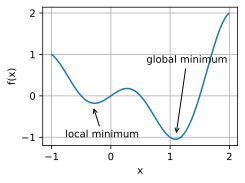

In [4]:
x = torch.arange(-1.0, 2.0, 0.01)
d2l.plot(
    x,
    [
        f(x),
    ],
    "x",
    "f(x)",
)
annotate("local minimum", (-0.3, -0.25), (-0.77, -1.0))
annotate("global minimum", (1.1, -0.95), (0.6, 0.8))

### 12.1.2.2. Saddle Points

$$f(x) = x^3$$

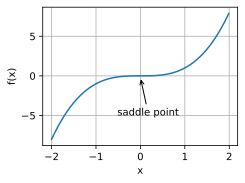

In [5]:
x = torch.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], "x", "f(x)")
annotate("saddle point", (0, -0.2), (-0.52, -5.0))

$$f(x, y) = x^2 - y^2$$

/home/pqian/miniconda3/envs/llama3/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647369228/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.5, 'y')

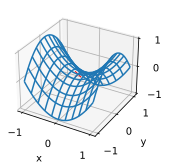

In [6]:
x, y = torch.meshgrid(torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection="3d")
ax.plot_wireframe(x, y, z, **{"rstride": 10, "cstride": 10})
ax.plot([0], [0], [0], "rx")
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel("x")
d2l.plt.ylabel("y")

We assume that the input of a function is a k-dimensional vector and its output is a scalar, so its Hessian matrix will have eigenvalues. The solution of the function could be a local minimum, a local maximum, or a saddle point at a position where the function gradient is zero:

- When the eigenvalues of the function’s Hessian matrix at the zero-gradient position are all positive, we have a local minimum for the function.

- When the eigenvalues of the function’s Hessian matrix at the zero-gradient position are all negative, we have a local maximum for the function.

- When the eigenvalues of the function’s Hessian matrix at the zero-gradient position are negative and positive, we have a saddle point for the function.

### 12.1.2.3. Vanishing Gradients

Vanishing gradients can cause optimization to stall
$$f(x) = \tanh(x)$$

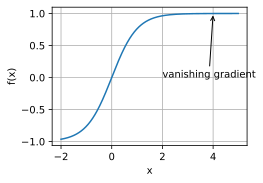

In [7]:
x = torch.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [torch.tanh(x)], "x", "f(x)")
annotate("vanishing gradient", (4, 1), (2, 0.0))

# 12.2. Convexity

## 12.2.1. Definitions

the cosine function is nonconvex, whereas the parabola and the exponential function are

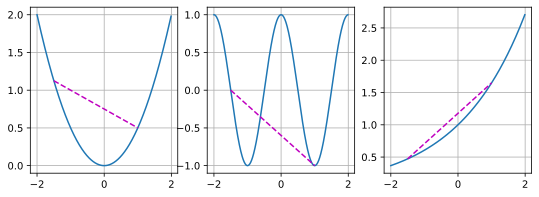

In [8]:
f = lambda x: 0.5 * x**2  # Convex
g = lambda x: torch.cos(np.pi * x)  # Nonconvex
h = lambda x: torch.exp(0.5 * x)  # Convex

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

## 12.2.2. Properties

the convex function $f(x) = (x-1)^2$ has a local minimum at $x=1$, which is also the global minimum

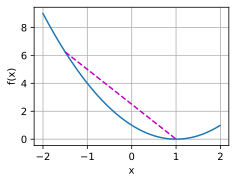

In [9]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], "x", "f(x)")

# 12.3. Gradient Descent

## 12.3.1. One-Dimensional Gradient Descent

In [10]:
def f(x):  # Objective function
    return x**2


def f_grad(x):  # Gradient (derivative) of the objective function
    return 2 * x

init $x=2, \eta=0.2$

In [11]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f"epoch 10, x: {x:f}")
    return results


results = gd(0.2, f_grad)

epoch 10, x: 0.060466


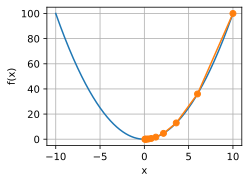

In [12]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot(
        [f_line, results],
        [[f(x) for x in f_line], [f(x) for x in results]],
        "x",
        "f(x)",
        fmts=["-", "-o"],
    )


show_trace(results, f)

### 12.3.1.1. Learning Rate

$\eta=0.05$  
If we use a learning rate that is too small, it will cause to update very slowly, requiring more iterations to get a better solution

epoch 10, x: 3.486784


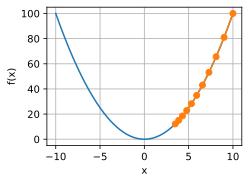

In [13]:
show_trace(gd(0.05, f_grad), f)

$\eta=1.1$  
$x$ overshoots the optimal solution $x=0$ and gradually diverges.

epoch 10, x: 61.917364


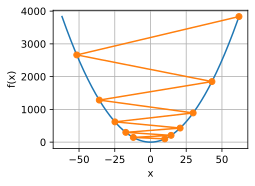

In [14]:
show_trace(gd(1.1, f_grad), f)

### 12.3.1.2. Local Minima

$$f(x) = x \cdot \cos(cx)$$
This function has infinitely many local minima.  
high learning rate will lead to a poor local minimum

epoch 10, x: -1.528166


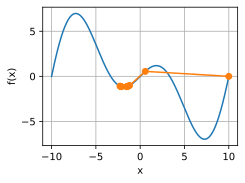

In [15]:
c = torch.tensor(0.15 * np.pi)


def f(x):  # Objective function
    return x * torch.cos(c * x)


def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)


show_trace(gd(2, f_grad), f)

## 12.3.2. Multivariate Gradient Descent

In [16]:
def train_2d(trainer, steps=20, f_grad=None):  # @save
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f"epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}")
    return results


def show_trace_2d(f, results):  # @save
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), "-o", color="#ff7f0e")
    x1, x2 = torch.meshgrid(
        torch.arange(-5.5, 1.0, 0.1), torch.arange(-3.0, 1.0, 0.1), indexing="ij"
    )
    d2l.plt.contour(x1, x2, f(x1, x2), colors="#1f77b4")
    d2l.plt.xlabel("x1")
    d2l.plt.ylabel("x2")

epoch 20, x1: -0.057646, x2: -0.000073


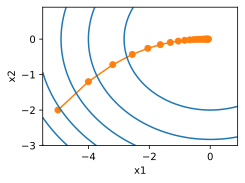

In [17]:
def f_2d(x1, x2):  # Objective function
    return x1**2 + 2 * x2**2


def f_2d_grad(x1, x2):  # Gradient of the objective function
    return (2 * x1, 4 * x2)


def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)


eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

## 12.3.3. Adaptive Methods

Newton's method

$$f(x) = \cosh(cx)$$

epoch 10, x: tensor(0.)


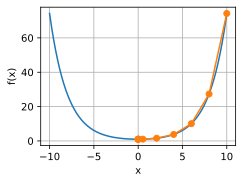

In [18]:
c = torch.tensor(0.5)


def f(x):  # Objective function
    return torch.cosh(c * x)


def f_grad(x):  # Gradient of the objective function
    return c * torch.sinh(c * x)


def f_hess(x):  # Hessian of the objective function
    return c**2 * torch.cosh(c * x)


def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print("epoch 10, x:", x)
    return results


show_trace(newton(), f)

a nonconvex function
$$f(x) = x \cos(c x)$$  
if the second derivative is negative we may walk into the direction of increasing the value of $f$  
That is a fatal flaw of the algorithm. 

epoch 10, x: tensor(26.8341)


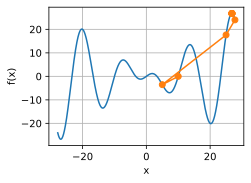

In [19]:
c = torch.tensor(0.15 * np.pi)


def f(x):  # Objective function
    return x * torch.cos(c * x)


def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)


def f_hess(x):  # Hessian of the objective function
    return -2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)


show_trace(newton(), f)

to fix this issue, we can either take the absolute value of Hessian or to bring back the learning rate  
here, we lower the learning rate

epoch 10, x: tensor(7.2699)


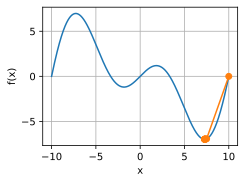

In [20]:
show_trace(newton(0.5), f)

# 12.4. Stochastic Gradient Descent

## 12.4.1. Stochastic Gradient Updates

the trajectory of the variables in the stochastic gradient descent is much more noisy than the one we observed in gradient descent  
stochastic gradient is a good estimate of the gradient

epoch 50, x1: -0.088170, x2: 0.070989


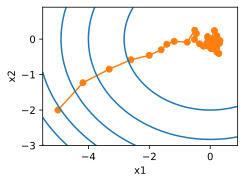

In [21]:
def f(x1, x2):  # Objective function
    return x1**2 + 2 * x2**2


def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2


def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)


def constant_lr():
    return 1


eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

## 12.4.2. Dynamic Learning Rate

\begin{split}\begin{aligned}
    \eta(t) & = \eta_i \textrm{ if } t_i \leq t \leq t_{i+1}  && \textrm{piecewise constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \textrm{exponential decay} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \textrm{polynomial decay}
\end{aligned}\end{split}

exponential decay  
the variance in the parameters is significantly reduced. However, this comes at the expense of failing to converge to the optimal solution $x=(0,0)$ 

epoch 1000, x1: -0.805217, x2: -0.058545


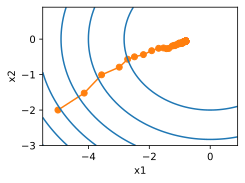

In [22]:
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)


t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

polynomial decay  
convergence gets better after only 50 steps

epoch 50, x1: 0.012270, x2: -0.009872


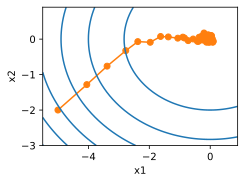

In [23]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)


t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

# 12.5. Minibatch Stochastic Gradient Descent

## 12.5.1. Vectorization and Caches

In [24]:
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

In [25]:
class Timer:  # @save
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


timer = Timer()

In [26]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

0.3182401657104492

In [27]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.01667189598083496

In [28]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

gigaflops = [0.03 / i for i in timer.times]
print(
    f"performance in Gigaflops: element {gigaflops[0]:.3f}, "
    f"column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}"
)

performance in Gigaflops: element 0.094, column 1.799, full 143.805


perform the entire operation in one block is the most efficient

## 12.5.2. Minibatches

the computation on the minibatch is essentially as efficient as on the full matrix

In [29]:
timer.start()
for j in range(0, 256, 64):
    A[:, j : j + 64] = torch.mm(B, C[:, j : j + 64])
timer.stop()
print(f"performance in Gigaflops: block {0.03 / timer.times[3]:.3f}")

performance in Gigaflops: block 90.007


## 12.5.3. Reading the Dataset

In [30]:
# @save
d2l.DATA_HUB["airfoil"] = (
    d2l.DATA_URL + "airfoil_self_noise.dat",
    "76e5be1548fd8222e5074cf0faae75edff8cf93f",
)


# @save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download("airfoil"), dtype=np.float32, delimiter="\t")
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]), batch_size, is_train=True)
    return data_iter, data.shape[1] - 1

## 12.5.4. Implementation from Scratch

In [31]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams["lr"] * p.grad)
        p.grad.data.zero_()

In [32]:
# @save
def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(
        xlabel="epoch", ylabel="loss", xlim=[0, num_epochs], ylim=[0.22, 0.35]
    )
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(
                    n / X.shape[0] / len(data_iter),
                    (d2l.evaluate_loss(net, data_iter, loss),),
                )
                timer.start()
    print(f"loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch")
    return timer.cumsum(), animator.Y[0]

batch_size to 1500 (i.e., to the total number of examples) = gradient descent

loss: 0.244, 0.006 sec/epoch


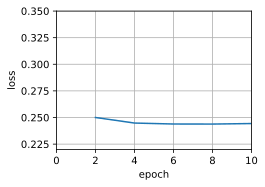

In [33]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(sgd, None, {"lr": lr}, data_iter, feature_dim, num_epochs)


gd_res = train_sgd(1, 1500, 10)

batch_size to 1 = stochastic gradient descent  
stochastic gradient descent consumes more time than gradient descent

loss: 0.244, 0.115 sec/epoch


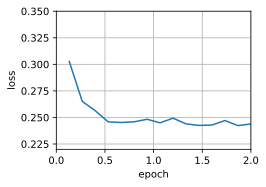

In [34]:
sgd_res = train_sgd(0.005, 1)

batch_size = 100  
The time required per epoch is shorter than the time needed for stochastic gradient descent and the time for batch gradient descent.

loss: 0.246, 0.006 sec/epoch


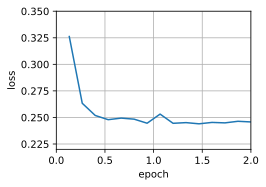

In [35]:
mini1_res = train_sgd(0.4, 100)

Reducing the batch size to 10, the time for each epoch increases because the workload for each batch is less efficient to execute.

loss: 0.243, 0.016 sec/epoch


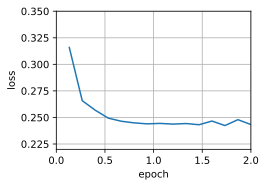

In [36]:
mini2_res = train_sgd(0.05, 10)

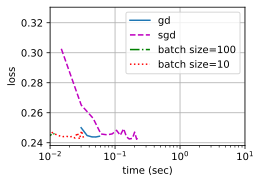

In [37]:
d2l.set_figsize([6, 3])
d2l.plot(
    *list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
    "time (sec)",
    "loss",
    xlim=[1e-2, 10],
    legend=["gd", "sgd", "batch size=100", "batch size=10"]
)
d2l.plt.gca().set_xscale("log")

- although stochastic gradient descent converges faster than GD in terms of number of examples processed, it uses more time to reach the same loss than GD  
- Minibatch stochastic gradient descent is able to trade-off convergence speed and computation efficiency.  
-- A minibatch size of 10 is more efficient than stochastic gradient descent  
-- a minibatch size of 100 even outperforms GD in terms of runtime.

## 12.5.5. Concise Implementation

In [38]:
# @save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))

    def init_weights(module):
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.01)

    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction="none")
    animator = d2l.Animator(
        xlabel="epoch", ylabel="loss", xlim=[0, num_epochs], ylim=[0.22, 0.35]
    )
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # `MSELoss` computes squared error without the 1/2 factor
                animator.add(
                    n / X.shape[0] / len(data_iter),
                    (d2l.evaluate_loss(net, data_iter, loss) / 2,),
                )
                timer.start()
    print(f"loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch")

loss: 0.242, 0.020 sec/epoch


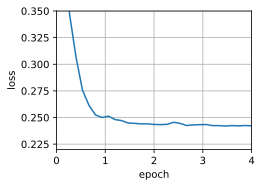

In [39]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {"lr": 0.01}, data_iter)

# 12.6. Momentum

## 12.6.1. Basics

### 12.6.1.2. An Ill-conditioned Problem

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$$
the gradient in the $x_2$ direction is much higher and changes much more rapidly than in the horizontal $x_1$ direction

epoch 20, x1: -0.943467, x2: -0.000073


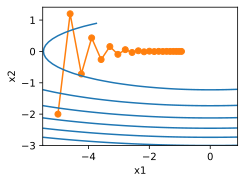

In [40]:
eta = 0.4


def f_2d(x1, x2):
    return 0.1 * x1**2 + 2 * x2**2


def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)


d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

epoch 20, x1: -0.387814, x2: -1673.365109


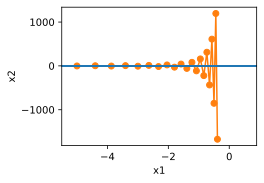

In [41]:
eta = 0.6  # change from 0.4 to 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### 12.6.1.3. The Momentum Method

\begin{split}\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}\end{split}

epoch 20, x1: 0.007188, x2: 0.002553


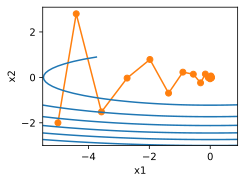

In [42]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2


eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

epoch 20, x1: -0.126340, x2: -0.186632


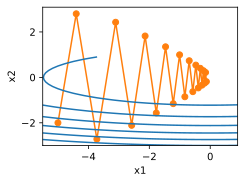

In [43]:
eta, beta = 0.6, 0.25  # halve beta to 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

weighting behaves for different choices of $\beta$
 

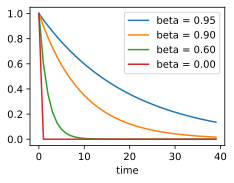

In [44]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta**x, label=f"beta = {beta:.2f}")
d2l.plt.xlabel("time")
d2l.plt.legend()

## 12.6.2. Practical Experiments

### 12.6.2.1. Implementation from Scratch

In [45]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)


def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams["momentum"] * v + p.grad
            p[:] -= hyperparams["lr"] * v
        p.grad.data.zero_()

loss: 0.246, 0.019 sec/epoch


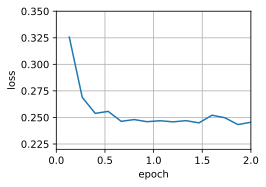

In [46]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(
        sgd_momentum,
        init_momentum_states(feature_dim),
        {"lr": lr, "momentum": momentum},
        data_iter,
        feature_dim,
        num_epochs,
    )


data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

loss: 0.256, 0.019 sec/epoch


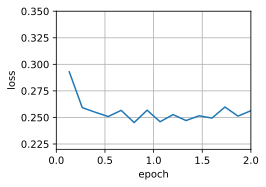

In [47]:
train_momentum(0.01, 0.9)

Reducing the learning rate further addresses any issue of non-smooth optimization problems. Setting it to 0.005 yields good convergence properties.

loss: 0.244, 0.019 sec/epoch


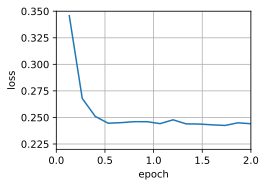

In [48]:
train_momentum(0.005, 0.9)

### 12.6.2.2. Concise Implementation

loss: 0.246, 0.021 sec/epoch


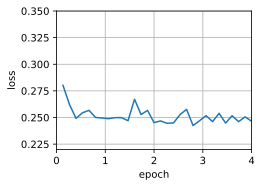

In [49]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {"lr": 0.005, "momentum": 0.9}, data_iter)

## 12.6.3. Theoretical Analysis

if $\eta \lambda < 1$, function can converge

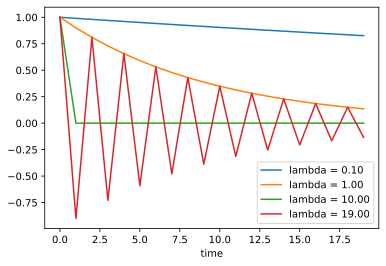

In [50]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f"lambda = {lam:.2f}")
d2l.plt.xlabel("time")
d2l.plt.legend()

# 12.7. Adagrad

## 12.7.3. The Algorithm

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$
the iterative trajectory of the independent variable is smoother.  
However, due to the cumulative effect of $s_t$, the learning rate continuously decays, so the independent variable does not move as much during later stages of iteration.

epoch 20, x1: -2.382563, x2: -0.158591


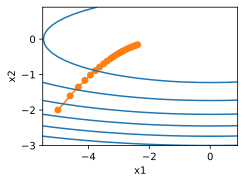

In [51]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1**2
    s2 += g2**2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2


def f_2d(x1, x2):
    return 0.1 * x1**2 + 2 * x2**2


eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

epoch 20, x1: -0.002295, x2: -0.000000


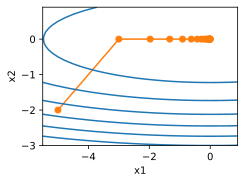

In [52]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## 12.7.4. Implementation from Scratch

In [53]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)


def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams["lr"] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

loss: 0.242, 0.021 sec/epoch


([0.003958940505981445,
  0.0067920684814453125,
  0.009532928466796875,
  0.012257575988769531,
  0.01498103141784668,
  0.017690181732177734,
  0.020400285720825195,
  0.02325892448425293,
  0.02596259117126465,
  0.028685331344604492,
  0.031484127044677734,
  0.03425168991088867,
  0.036965370178222656,
  0.03966832160949707,
  0.04248332977294922],
 [0.272705837726593,
  0.25756472468376157,
  0.24908837389945984,
  0.24230531109372774,
  0.24717749629418057,
  0.24566895675659178,
  0.24259810678164165,
  0.24298194420337677,
  0.24293412232398987,
  0.24335669483741124,
  0.2439144935409228,
  0.24208547071615855,
  0.2426613270441691,
  0.24346836118896803,
  0.24196869798501333])

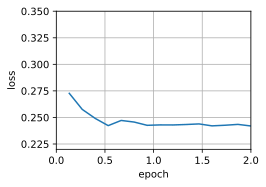

In [54]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(
    adagrad, init_adagrad_states(feature_dim), {"lr": 0.1}, data_iter, feature_dim
)

## 12.7.5. Concise Implementation

loss: 0.242, 0.025 sec/epoch


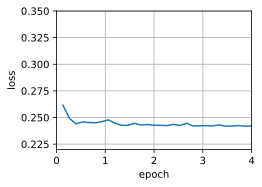

In [55]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {"lr": 0.1}, data_iter)

# 12.8. RMSProp

## 12.8.1. The Algorithm

visualize the weights for the past 40 time steps for various choices $\gamma$.

Text(0.5, 0, 'time')

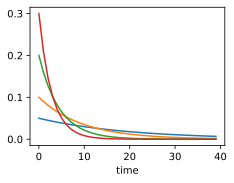

In [56]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1 - gamma) * gamma**x, label=f"gamma = {gamma:.2f}")
d2l.plt.xlabel("time")

## 12.8.2. Implementation from Scratch

\begin{split}\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}\end{split}

$$f(\mathbf{x})=0.1x_1^2+2x_2^2$$

epoch 20, x1: -0.010599, x2: 0.000000


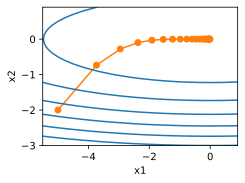

In [57]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1**2
    s2 = gamma * s2 + (1 - gamma) * g2**2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2


def f_2d(x1, x2):
    return 0.1 * x1**2 + 2 * x2**2


eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [58]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)


def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams["gamma"], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams["lr"] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

loss: 0.244, 0.022 sec/epoch


([0.0030014514923095703,
  0.005889177322387695,
  0.00892329216003418,
  0.011856317520141602,
  0.014714956283569336,
  0.01756453514099121,
  0.020489215850830078,
  0.023508071899414062,
  0.026408672332763672,
  0.029338836669921875,
  0.03221869468688965,
  0.03505134582519531,
  0.03798174858093262,
  0.04085707664489746,
  0.043682098388671875],
 [0.3431298845211665,
  0.29792776425679524,
  0.26447470078865687,
  0.24973190275828044,
  0.24660003153483073,
  0.24430182077487309,
  0.2446001562078794,
  0.24617677191893259,
  0.24357371135552724,
  0.24282968972126642,
  0.24299323397874834,
  0.24346755079428356,
  0.24464856330553691,
  0.24226581037044526,
  0.2444102916320165])

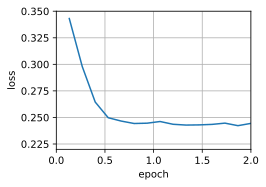

In [59]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(
    rmsprop,
    init_rmsprop_states(feature_dim),
    {"lr": 0.01, "gamma": 0.9},
    data_iter,
    feature_dim,
)

## 12.8.3. Concise Implementation

loss: 0.249, 0.025 sec/epoch


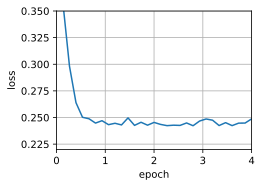

In [60]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {"lr": 0.01, "alpha": 0.9}, data_iter)

# 12.9. Adadelta

\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2 \\
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t' \\
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2
\end{aligned}

In [61]:
def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))


def adadelta(params, states, hyperparams):
    rho, eps = hyperparams["rho"], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-place updates via [:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

loss: 0.243, 0.024 sec/epoch


([0.0032634735107421875,
  0.006412506103515625,
  0.009619474411010742,
  0.012780427932739258,
  0.015928983688354492,
  0.019052982330322266,
  0.022246360778808594,
  0.025497913360595703,
  0.0286409854888916,
  0.031804800033569336,
  0.03499650955200195,
  0.038179874420166016,
  0.04133749008178711,
  0.04449200630187988,
  0.047681331634521484],
 [0.37443838342030844,
  0.3160416378180186,
  0.2781347696582476,
  0.2618989924589793,
  0.2497852072318395,
  0.24725326371192932,
  0.24616770058870316,
  0.24508009552955629,
  0.2472825467189153,
  0.24293661153316498,
  0.24796974941094715,
  0.24457820017139117,
  0.2429128831823667,
  0.2430778125723203,
  0.2431934731801351])

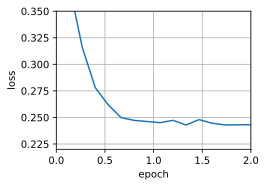

In [62]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(
    adadelta, init_adadelta_states(feature_dim), {"rho": 0.9}, data_iter, feature_dim
)

loss: 0.242, 0.026 sec/epoch


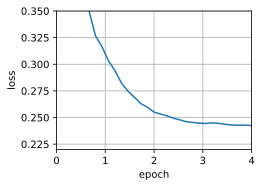

In [63]:
# concise implementation
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {"rho": 0.9}, data_iter)

# 12.10. Adam

- SGD is more effective than GD
- minibatch SGD gains significant additional efficiency arising from vectorization
- momentum added a mechanism for aggregating a history of past gradients to accelerate convergence
- Adagrad used per-coordinate scaling to allow for a computationally efficient preconditioner
- RMSProp decoupled per-coordinate scaling from a learning rate adjustment

## 12.10.2. Implementation

\begin{split}\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.\\
    \hat{\mathbf{v}}_t & = \frac{\mathbf{v}_t}{1 - \beta_1^t} \textrm{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.\\
    \mathbf{g}_t' & = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.\\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.
\end{aligned}\end{split}

In [64]:
def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))


def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams["t"])
            s_bias_corr = s / (1 - beta2 ** hyperparams["t"])
            p[:] -= hyperparams["lr"] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
        p.grad.data.zero_()
    hyperparams["t"] += 1

loss: 0.246, 0.025 sec/epoch


([0.003387451171875,
  0.006627321243286133,
  0.009927511215209961,
  0.01315164566040039,
  0.016516923904418945,
  0.019949674606323242,
  0.02323293685913086,
  0.02671194076538086,
  0.030019521713256836,
  0.033270835876464844,
  0.036585092544555664,
  0.039859771728515625,
  0.04323458671569824,
  0.04671812057495117,
  0.05011582374572754],
 [0.3892500122388204,
  0.31489170893033347,
  0.27459258496761324,
  0.25207051968574523,
  0.24740089253584543,
  0.2436313082377116,
  0.2441984156469504,
  0.24874700442949932,
  0.24293251019716264,
  0.2448262095451355,
  0.24347423241535823,
  0.2445106443564097,
  0.24209299119313557,
  0.24287493101755778,
  0.24555453987916312])

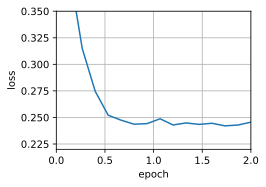

In [65]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(
    adam, init_adam_states(feature_dim), {"lr": 0.01, "t": 1}, data_iter, feature_dim
)

loss: 0.243, 0.028 sec/epoch


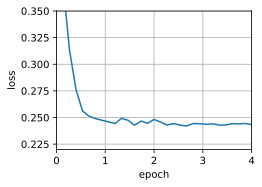

In [66]:
# concise implementation
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {"lr": 0.01}, data_iter)

## 12.10.3. Yogi

\begin{split}\begin{aligned}
    \mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\textrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).
\end{aligned}\end{split}

loss: 0.243, 0.026 sec/epoch


([0.0035681724548339844,
  0.007093906402587891,
  0.0105133056640625,
  0.013959884643554688,
  0.017401456832885742,
  0.02087569236755371,
  0.024309635162353516,
  0.027860164642333984,
  0.03133511543273926,
  0.03466534614562988,
  0.03808784484863281,
  0.04149961471557617,
  0.04486703872680664,
  0.04825234413146973,
  0.05167436599731445],
 [0.38123333700497947,
  0.30534730982780456,
  0.27397582868734993,
  0.25836495459079745,
  0.25042778279383976,
  0.24970838550726573,
  0.24437045208613078,
  0.24723725895086923,
  0.24489539575576783,
  0.24584057414531707,
  0.24242417232195537,
  0.24889807045459747,
  0.2479055554072062,
  0.24609707061449687,
  0.24304269433021544])

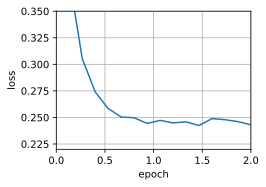

In [67]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s
            ) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams["t"])
            s_bias_corr = s / (1 - beta2 ** hyperparams["t"])
            p[:] -= hyperparams["lr"] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
        p.grad.data.zero_()
    hyperparams["t"] += 1


data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(
    yogi, init_adam_states(feature_dim), {"lr": 0.01, "t": 1}, data_iter, feature_dim
)

# 12.11. Learning Rate Scheduling

## 12.11.1. Toy Problem

In [68]:
def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
    )

    return model


loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)


# The code is almost identical to `d2l.train_ch6` defined in the
# lenet section of chapter convolutional neural networks
def train(
    net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler=None
):
    net.to(device)
    animator = d2l.Animator(
        xlabel="epoch",
        xlim=[0, num_epochs],
        legend=["train loss", "train acc", "test acc"],
    )

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # Using PyTorch In-Built scheduler
                scheduler.step()
            else:
                # Using custom defined scheduler
                for param_group in trainer.param_groups:
                    param_group["lr"] = scheduler(epoch)

    print(
        f"train loss {train_loss:.3f}, train acc {train_acc:.3f}, "
        f"test acc {test_acc:.3f}"
    )

train loss 0.153, train acc 0.943, test acc 0.886


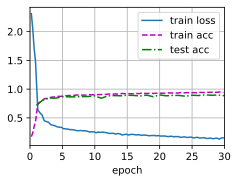

In [69]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

the training accuracy keeps on increasing while progress in terms of test accuracy stalls beyond a point. The gap between both curves indicates overfitting

## 12.11.2. Schedulers

In [70]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


$$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$$

In [71]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

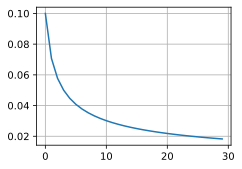

In [72]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.282, train acc 0.897, test acc 0.877


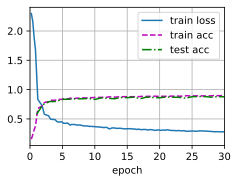

In [73]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

- the curve was rather more smooth than previously
- there was less overfitting

 it is not a well-resolved question as to why certain strategies lead to less overfitting in theory

## 12.11.3. Policies

### 12.11.3.1. Factor Scheduler

$$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$$

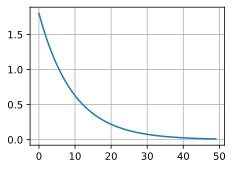

In [74]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr


scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

### 12.11.3.2. Multi Factor Scheduler

The intuition behind this piecewise constant learning rate schedule is that one lets optimization proceed until a stationary point has been reached in terms of the distribution of weight vectors. Then (and only then) do we decrease the rate such as to obtain a higher quality proxy to a good local minimum

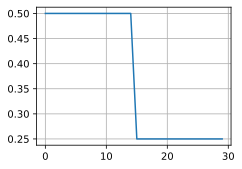

In [75]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)


def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr


d2l.plot(
    torch.arange(num_epochs), [get_lr(trainer, scheduler) for t in range(num_epochs)]
)

train loss 0.203, train acc 0.924, test acc 0.891


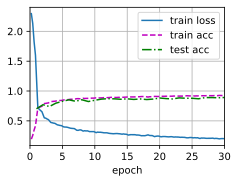

In [76]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

### 12.11.3.3. Cosine Scheduler

we might not want to decrease the learning rate too drastically in the beginning and moreover, that we might want to “refine” the solution in the end using a very small learning rate.
$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$

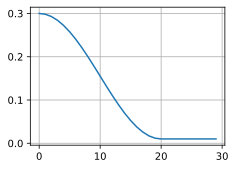

In [77]:
class CosineScheduler:
    def __init__(
        self, max_update, base_lr=0.01, final_lr=0, warmup_steps=0, warmup_begin_lr=0
    ):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (
            (self.base_lr_orig - self.warmup_begin_lr)
            * float(epoch)
            / float(self.warmup_steps)
        )
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = (
                self.final_lr
                + (self.base_lr_orig - self.final_lr)
                * (1 + math.cos(math.pi * (epoch - self.warmup_steps) / self.max_steps))
                / 2
            )
        return self.base_lr


scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.191, train acc 0.929, test acc 0.899


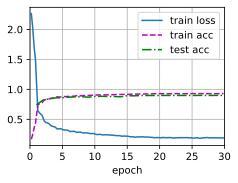

In [78]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

In the context of computer vision this schedule can lead to improved results. Note, though, that such improvements are not guaranteed

### 12.11.3.4. Warmup

use a warmup period during which the learning rate increases to its initial maximum and to cool down the rate until the end of the optimization process

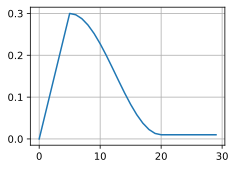

In [79]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.184, train acc 0.932, test acc 0.904


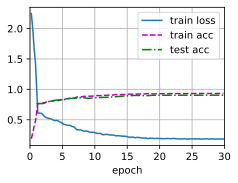

In [80]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)